# Faire - The Online Wholesale Marketplace & Store

Welcome! Lets build a new search ranking model.

### Description

Knowing whether a Product in Search will be bought in advance could provide huge business value to Faire. This task is very important for purchase prediction as well as for short term user engagement prediction.

- In this dataset we have sampled ~20k rows from Faire search logs. The dataset is anonymized. Before describing the dataset, lets give some preliminary knowledge of how Faire Wholesale MarketPlace Search works. Faire is a two-sided marketplace where retailers come to shop wholesale products from brands. When a retailer makes a search on the site, we call that a search request. The response is a page with many products. We assign a `request_id` to this search request response, and different pages (page number 1, 2, 3...) from the same search have different `request_id`s (i.e. `request_id` is more of a "page id" than a "search session id"). Each row in this dataset represents one single product that was impressed for that `request_id`. For each request_id you can have many results (due to this being a random sample some of them might be missed in a some cases). 

- Each row contains the following fields: `request_id`, `retailer_token` (anonymzed user token), `query_text` (the actual search string), `page_number`, `page_size`, `position`, `filter_string` (filters applied on top of the search), `has_product_click` (was it clicked or not). 
- We have some features from our feature store (computed using data from before the search timestamp): anything starting with `product.` is a product-level feature. We have also a few personalization features in this dataset, anything starting with `retailerbrand.` is a personalization feature and relates to a particular retailer:brand pair. 
- Note that we have personalization features only at the level of retailer(user) and the brand the product belongs to. Brands usually have many products in our marketplace, so Product <-> Brand mapping is Many:1.

### Tasks
In approximately 1 hour, please do the following:
- Please build first a ranking model using the provided dataset and evaluate it. 
- If there is time, please implement 1 or 2 additional features, and list up to 10 more features (without implementing them).
- If there is time, please give us an idea of the next steps, how would you improve this model if you had 1 week more, 1 month more, or 3 months more?

Please write as many comments or communicate out loud your thought process. Once your time allocation is up, please send back the completed notebook in .ipynb and .pdf format

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import csv

In [2]:
data = pd.read_csv("datasets/faire-ml-rank-small.csv")
data

,Unnamed: 0.1,Unnamed: 0,product.product_brand_page_click_to_cart_rate,product.product_brand_page_impression_to_click_rate,product.product_click_to_cart_rate_4w,product.product_impression_to_click_rate_4w,product.product_is_high_sell_through,product.product_num_cart_adds_4w,product.product_num_clicks_4w,product.product_num_impressions_4w,...,description,has_product_click,created_at_a,query_text,filter_string,page_number,page_size,position,retailer_token_anon,request_id_anon
0,26152,26152,1.0708,0.0133,NaN,NaN,0.0,NaN,NaN,303.0,...,Hat-leopard visor sun hat.,0,2020-05-31 00:22:33.18,sun hat,NaN,0.0,48,23.0,188,1433
1,26890,26890,1.9197,0.0134,NaN,NaN,0.0,NaN,NaN,77.0,...,"Offbeat, cheeky and distinctive greeting cards...",0,2020-05-31 01:21:00.418,beach,NaN,23.0,24,559.0,132,703
2,41983,41983,0.6080,0.0423,NaN,NaN,0.0,NaN,NaN,50.0,...,"Selene, considered the human personification o...",0,2020-05-31 23:34:57.391,gold love necklace,NaN,1.0,48,58.0,81,516
3,49020,49020,0.3170,0.0066,NaN,NaN,0.0,NaN,NaN,133.0,...,Black plastic letter set for changeable felt l...,0,2020-05-31 14:50:05.476,letter board,NaN,0.0,48,48.0,728,940
4,42438,42438,0.6645,0.0126,NaN,NaN,0.0,NaN,NaN,137.0,...,Our Dakota Signs are handcrafted from real woo...,0,2020-05-31 21:58:00.131,porch signs,NaN,0.0,50,44.0,265,1312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,42446,42446,0.1731,0.0370,NaN,0.0152,0.0,NaN,NaN,1379.0,...,"Available to ship May 5th\nTimes are changing,...",0,2020-05-31 18:31:47.869,disposable face masks,NaN,0.0,50,27.0,375,113
19996,19547,19547,0.4884,0.0027,NaN,NaN,0.0,NaN,NaN,21.0,...,The Venetian velvet ice blue throw pillow is a...,0,2020-05-31 16:59:00.189,venetian decor,NaN,0.0,48,33.0,1,798
19997,53349,14033,0.1678,0.0215,NaN,NaN,0.0,NaN,NaN,187.0,...,This fragrance captures the essence of summer ...,1,2020-05-31 01:19:51.101,beach,NaN,22.0,24,529.0,132,542
19998,27780,27780,0.5083,0.0446,NaN,NaN,0.0,NaN,NaN,94.0,...,Light nude – flattering on all skin tones.\nSa...,0,2020-05-31 23:54:27.353,lip gloss,NaN,3.0,24,86.0,534,156


In [3]:
# data.head(10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Unnamed: 0.1                                                                20000 non-null  int64  
 1   Unnamed: 0                                                                  20000 non-null  int64  
 2   product.product_brand_page_click_to_cart_rate                               19813 non-null  float64
 3   product.product_brand_page_impression_to_click_rate                         19815 non-null  float64
 4   product.product_click_to_cart_rate_4w                                       301 non-null    float64
 5   product.product_impression_to_click_rate_4w                                 4555 non-null   float64
 6   product.product_is_high_sell_through          

[]

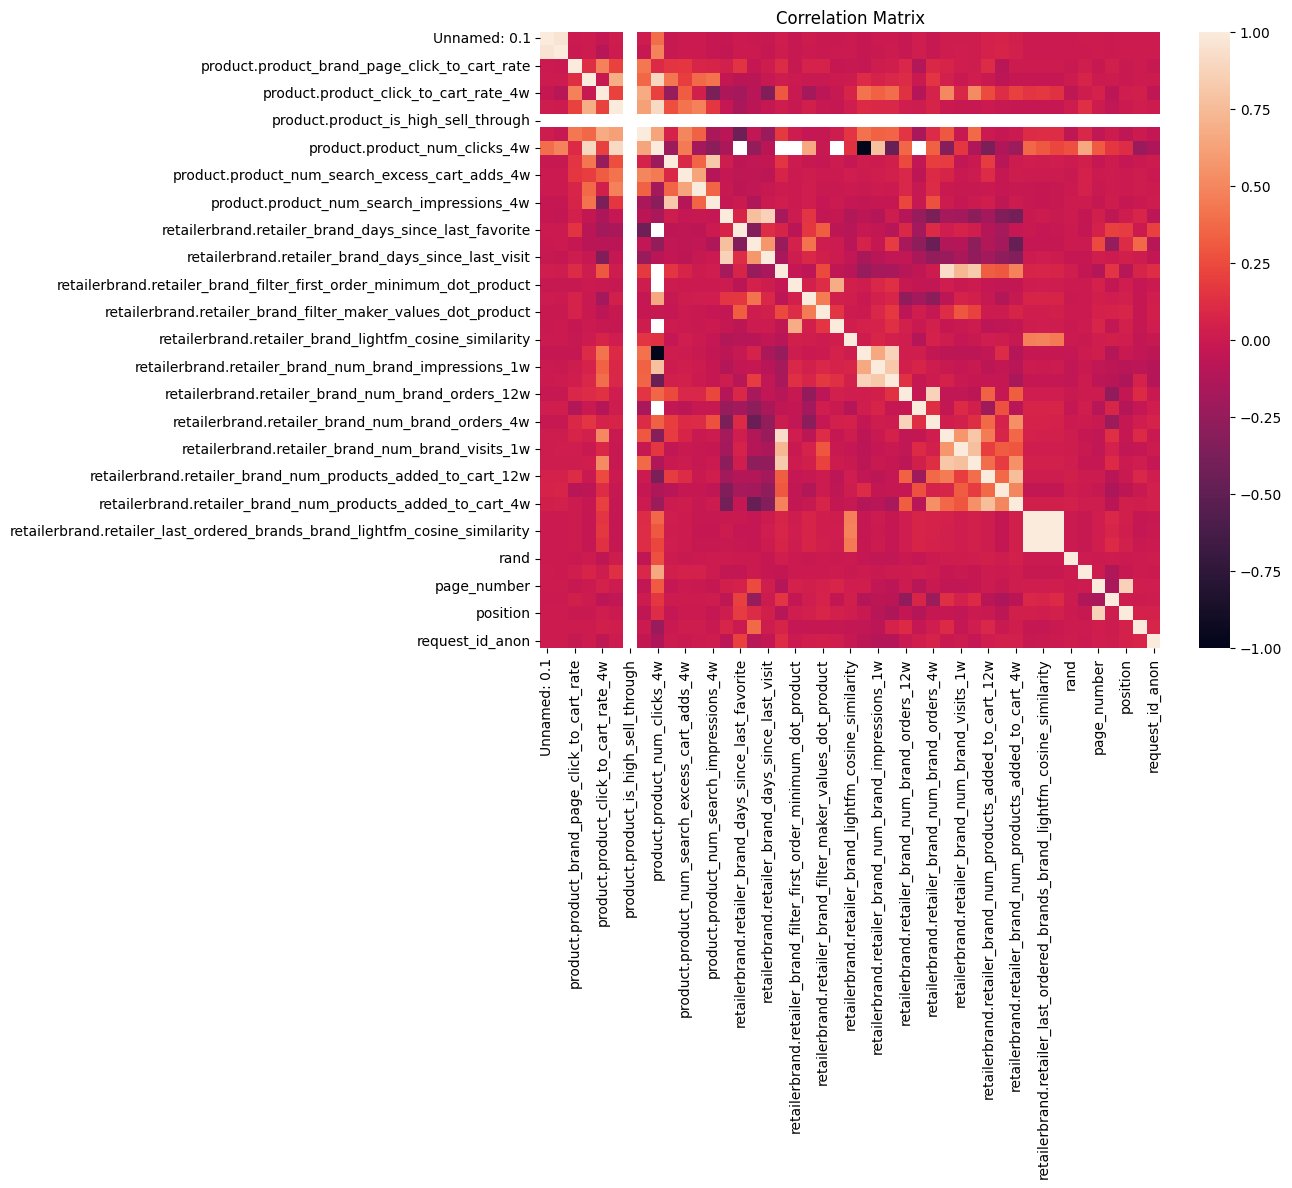

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

corr_features = data.select_dtypes(include=[np.number])
corr = corr_features.corr()

plt.figure(figsize=[10,8])
sns.heatmap(corr)
plt.title('Correlation Matrix')
plt.plot()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 7

def prepare_data(features, scale=False):
    # remove unwanted columns
    numeric_features = features.select_dtypes(include=[np.number])
    numeric_features = numeric_features.drop(["Unnamed: 0.1", "Unnamed: 0", "retailer_token_anon", "rand"], axis=1)
    
    numeric_features = numeric_features.fillna(0)

    # print(numeric_data.describe())
    # split the data into training and testing sets uing request_id_annon as the target variable
    request_id_annon = numeric_features['request_id_anon'].unique()
    X_train_rid, X_test_rid = train_test_split(request_id_annon, test_size=0.2, random_state=RANDOM_STATE)

    X1 = numeric_features[numeric_features['request_id_anon'].isin(X_train_rid)]
    X2 = numeric_features[numeric_features['request_id_anon'].isin(X_test_rid)]

    X1 = X1.drop(['request_id_anon'], axis=1)
    X2 = X2.drop(['request_id_anon'], axis=1)

   
   
    if scale:
        columns = X1.columns
        scaler = StandardScaler()
        X1 = scaler.fit_transform(X1)
        X2 = scaler.transform(X2)

        X1 = pd.DataFrame(X1, columns=columns)
        X2 = pd.DataFrame(X2, columns=columns)
    
    
    X_train = X1.drop('has_product_click', axis=1)
    Y_train = X1['has_product_click'].astype(int)
    X_test = X2.drop('has_product_click', axis=1)
    Y_test = X2['has_product_click'].astype(int)
    

    return X_train, Y_train, X_test, Y_test

In [7]:
def metrics(Y_test, Y_pred, Y_proba):
    class_probabilities = Y_proba[:, 1]
    print(f"Y_pred: {Y_pred[:3]}")
    print(f"Y_proba shape: {class_probabilities[:3]}")

    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    print(f"Confusion Matrix: \n{confusion_matrix(Y_test, Y_pred)}")
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(f"Precision: {precision_score(Y_test, Y_pred)}")
    print(f"Recall: {recall_score(Y_test, Y_pred)}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred)}")

    # print pr_auc score
    from sklearn.metrics import auc
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(Y_test, class_probabilities)
    print(f"PR AUC: {auc(recall, precision)}")




In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

def lr_model(current_data, scale=False):
    X_train, Y_train, X_test, Y_test = prepare_data(current_data, scale)
    lr = LogisticRegression(random_state=RANDOM_STATE)
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    print(f"Y_pred shape: {Y_pred.shape}")
    Y_proba = lr.predict_proba(X_test)
    metrics(Y_test, Y_pred, Y_proba)

    sorted_indices = lr.coef_[0].argsort()
    for i in range(1, 11):
        print(f"Feature: {X_train.columns[sorted_indices[-i]]}, Importance: {lr.coef_[0][sorted_indices[-i]]}")


lr_model(data)
lr_model(data, True)

/opt/homebrew/Caskroom/miniconda/base/envs/interview_prep/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Y_pred shape: (4259,)
Y_pred: [0 0 0]
Y_proba shape: [0.02025506 0.06376816 0.02172142]
Confusion Matrix: 
[[4085    2]
 [ 172    0]]
Accuracy: 0.9591453392815215
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.07815652981673282
Feature: product.product_num_search_excess_clicks_4w, Importance: 0.01986981073322904
Feature: product.product_num_search_excess_cart_adds_4w, Importance: 0.018494577480540383
Feature: retailerbrand.retailer_brand_days_since_last_order, Importance: 0.008132721163663748
Feature: retailerbrand.retailer_brand_num_brand_visits_1w, Importance: 0.005065153977762862
Feature: retailerbrand.retailer_brand_num_brand_visits_4w, Importance: 0.004588785543527971
Feature: retailerbrand.retailer_brand_days_since_last_visit, Importance: 0.0030411217533185472
Feature: retailerbrand.retailer_brand_num_brand_impressions_12w, Importance: 0.000986854738051938
Feature: retailerbrand.retailer_brand_num_brand_visits_12w, Importance: 0.0006008976545713805
Feature: product.product_nu

ValueError: pos_label=1 is not a valid label. It should be one of [0, 4]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def dt_model(current_data, scale=False):
    X_train, Y_train, X_test, Y_test = prepare_data(current_data, scale)
    dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10, min_samples_leaf=10, criterion='entropy')
    dtc.fit(X_train, Y_train)
    Y_pred = dtc.predict(X_test)

    metrics(Y_test, Y_pred)

    sorted_indices = dtc.feature_importances_.argsort()

    # print the top 10 features and their importance score
    for i in range(1, 11):
        print(f"Feature: {X_train.columns[sorted_indices[-i]]}, Importance: {dtc.feature_importances_[sorted_indices[-i]]}")


dt_model(numeric_data)
dt_model(numeric_data, scale=True)

In [ ]:

data['query_text'] = data['query_text'].str.lower()
data['title'] = data['title'].str.lower()
data['description'] = data['description'].str.lower()
# print(data[['query_text', 'title', 'description']].head(10))


# chekc if the query_text is present in the title column
data['query_in_title'] = data.apply(lambda x: 1 if x['query_text'] in x['title'] else 0, axis=1)

data['description'].fillna("", inplace=True)
# check if the query_text is present in the description column
data['query_text_in_description'] = data.apply(lambda x: 1 if x['query_text'] in x['description'] else 0, axis=1)

# data['query_text_in_description'].value_counts()
selected_data = data.select_dtypes(include=[np.number, bool])

dt_model(selected_data)
dt_model(selected_data, scale=True)
